In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import cv2
import os                                                        ## package for file path system
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical             ## encode numbers to one-hot encode form
from sklearn.preprocessing import LabelEncoder                ## encode string labels to numbers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout ,LayerNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

In [2]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], 512, 512, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (512, 512))
        yield (batch_crops, batch_y)

In [7]:
src_path_train = "../input/sp-society-camera-model-identification/train/train/"
src_path_test = "../input/sp-society-camera-model-identification/test/"

train_datagen = ImageDataGenerator(
        rescale=(1 / 255.0)**(0.8),
        rotation_range=25,
        zoom_range=0.25,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.25,
        horizontal_flip=True,
        fill_mode="nearest",
        dtype='int',
        validation_split=0.20)

In [8]:
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(1024, 1024),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    interpolation="bicubic",
    shuffle=True,
    seed=42
)
valid_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(1024, 1024),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    interpolation="bicubic",
    shuffle=True,
    seed=42
)
# test_generator = test_datagen.flow_from_directory(
#     directory=src_path_test,
#     target_size=(512, 512),
#     color_mode="rgb",
#     batch_size=1,
#     interpolation="bicubic",
#     class_mode=None,
#     shuffle=False,
#     seed=42
# )

Found 2200 images belonging to 10 classes.
Found 550 images belonging to 10 classes.


In [9]:
train_crops = crop_generator(train_generator, 512)
valid_crops = crop_generator(valid_generator, 512)

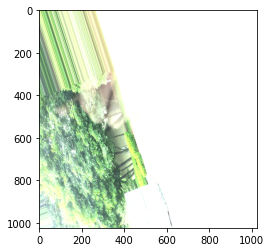

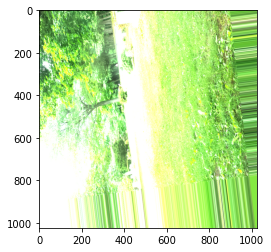

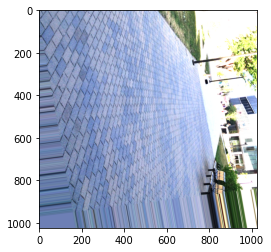

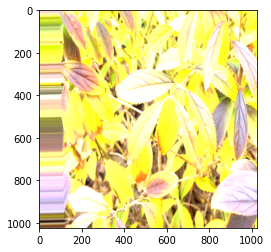

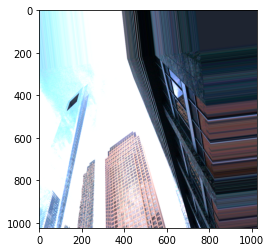

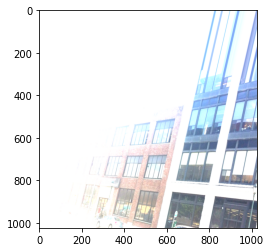

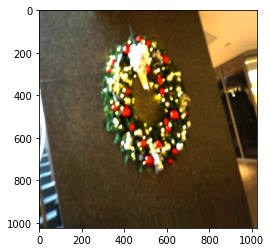

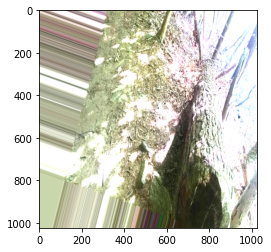

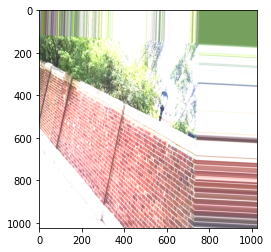

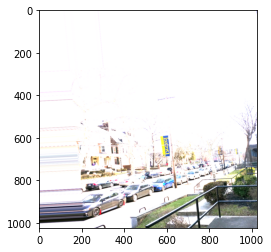

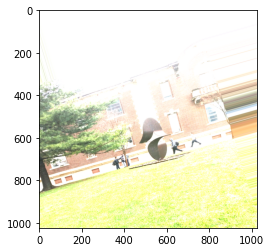

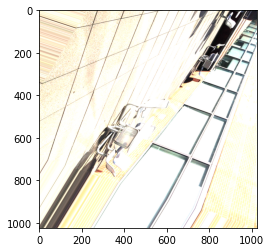

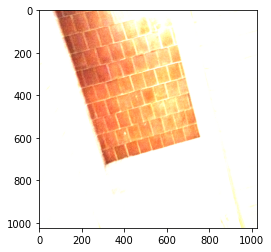

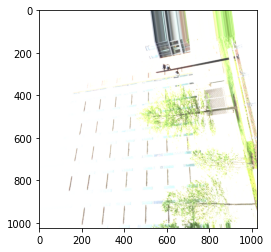

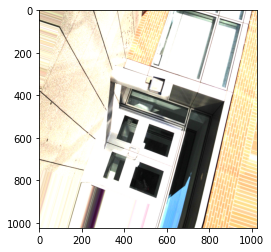

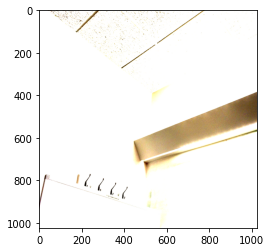

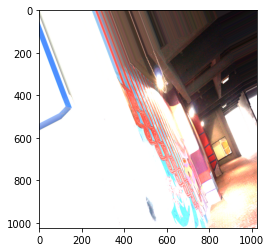

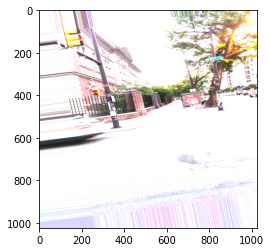

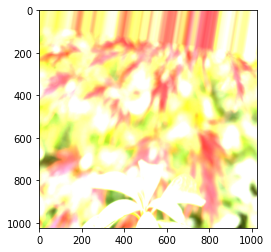

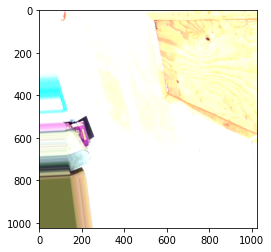

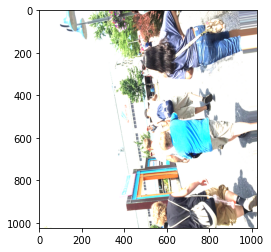

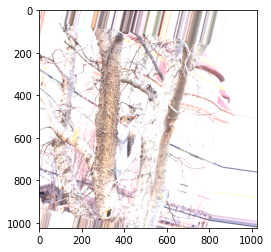

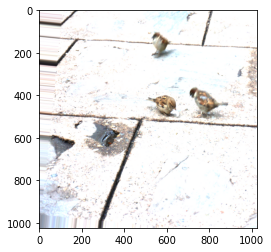

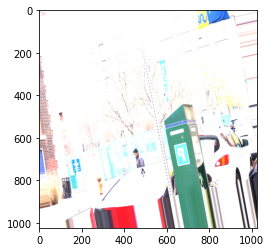

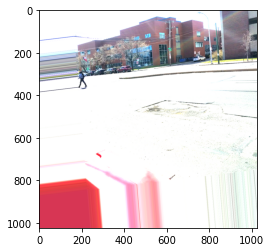

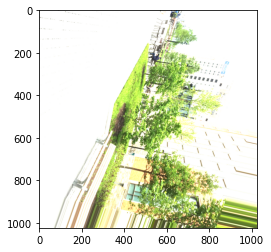

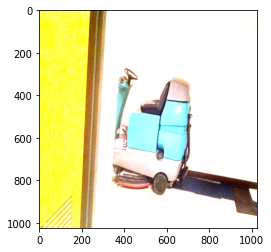

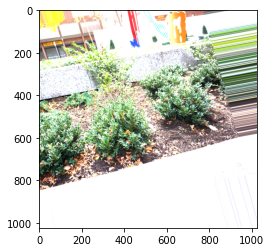

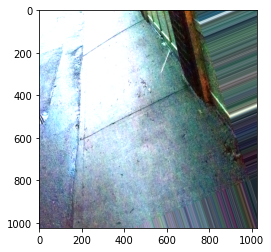

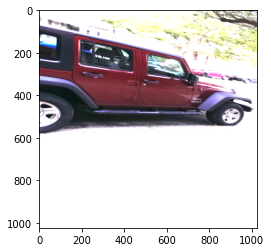

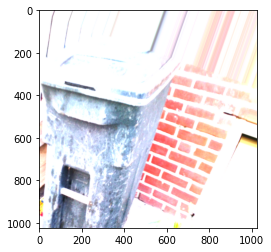

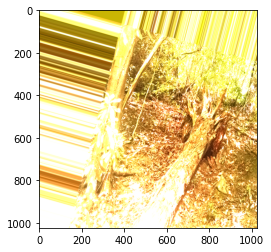

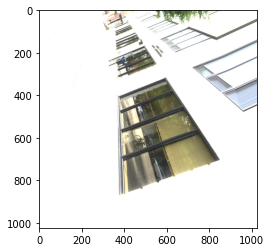

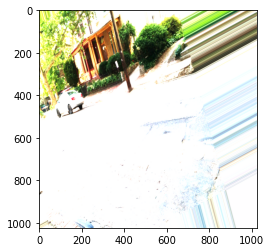

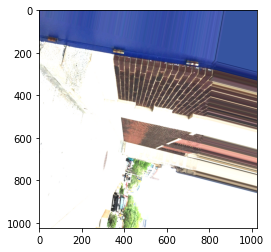

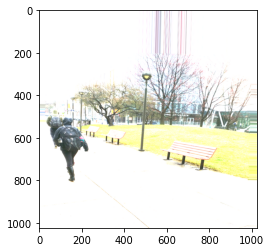

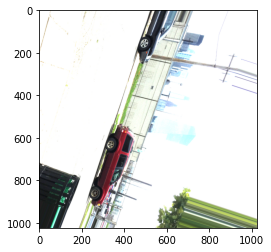

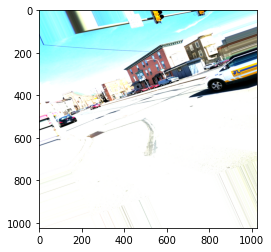

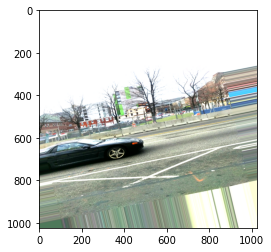

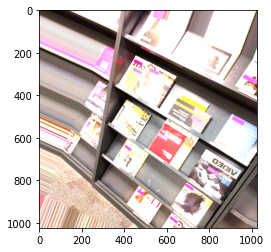

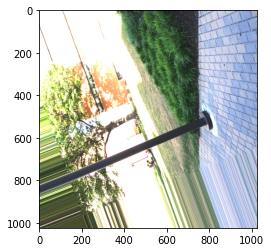

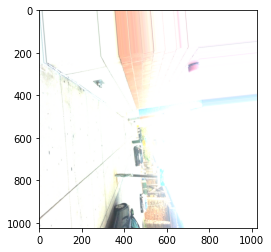

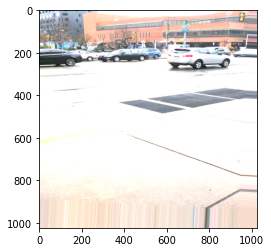

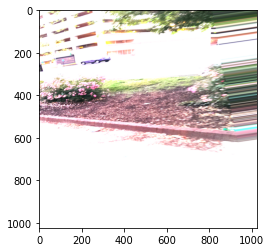

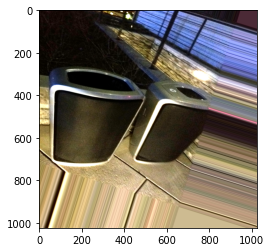

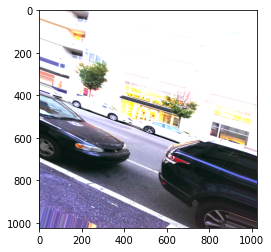

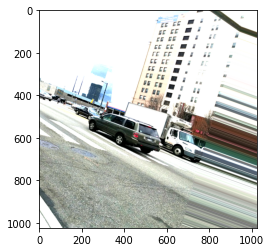

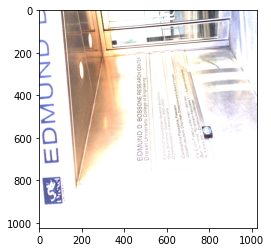

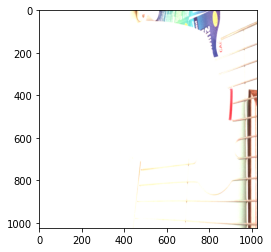

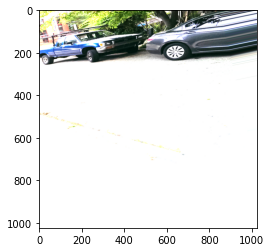

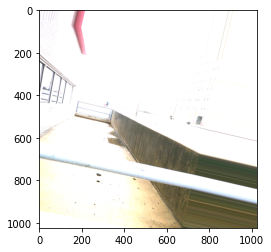

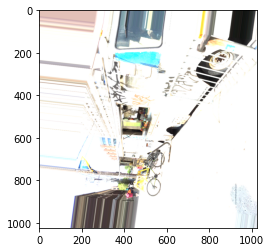

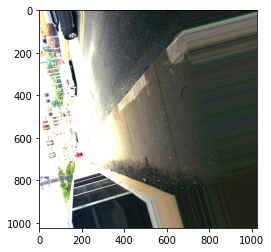

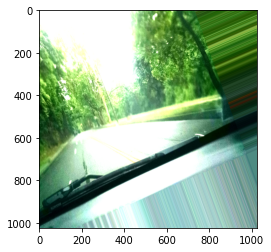

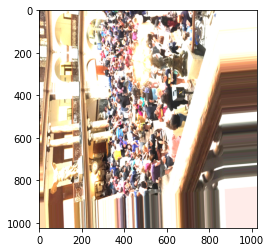

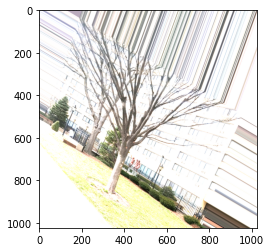

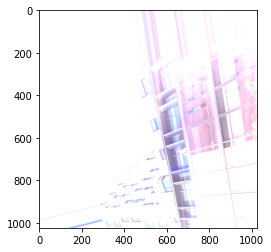

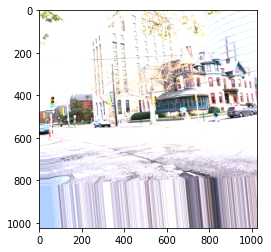

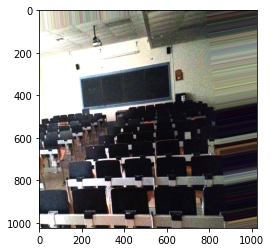

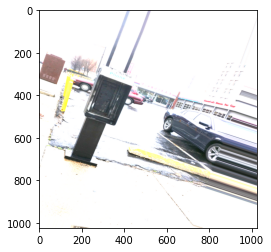

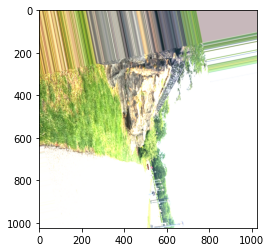

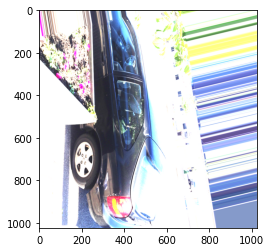

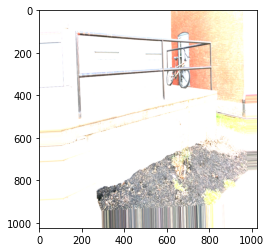

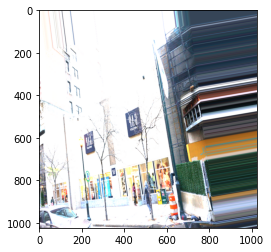

In [10]:
for mybatch in train_generator:
    image = mybatch[0]
    for i in range(len(image)):
        plt.imshow(image[i])
        plt.show()
    break

In [ ]:
model = Sequential()
model = keras.applications.DenseNet121(weights='imagenet', 
                                       include_top=False, 
                                       input_shape=(512, 512, 3))
model.trainable = False
inputs =keras.layers.Input(shape=(512,512,3))
x = keras.applications.densenet.preprocess_input(inputs)
x = model(x, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)

model =keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary() 

In [14]:
file_path = "weights_best.hdf5"

checkpoint = keras.callbacks.ModelCheckpoint(file_path, monitor="val_accuracy", save_best_only=True, mode='max')

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.9, patience=2, min_lr=1e-6, mode="max", verbose=True)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, mode="max", verbose=True)

callbacks_list = [checkpoint, reduce_lr, early_stopping]

In [17]:
import matplotlib.pyplot as plt
hist = model.fit(train_crops,
                    validation_data = valid_crops,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=10,callbacks=callbacks_list)


plt.plot(hist.history['loss'])                                               ## plot loss curve during training 
plt.plot(hist.history['val_loss'])
plt.legend(['train loss','validation loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(hist.history['accuracy'])                                               ## plot accuracy curve during training 
plt.plot(hist.history['val_accuracy'])
plt.legend(['train accuracy','validation accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

ValueError: generator already executing

In [26]:
sample_submission = pd.read_csv('../input/sp-society-camera-model-identification/sample_submission.csv')
sample_submission.head()

fname    camera
0  img_0002a04_manip.tif  iPhone-6
1  img_001e31c_unalt.tif  iPhone-6
2  img_00275cf_manip.tif  iPhone-6
3  img_0034113_unalt.tif  iPhone-6
4  img_00344b7_unalt.tif  iPhone-6

In [27]:
X_test = "../input/sp-society-camera-model-identification/test/test/"+ sample_submission['fname']
# X_test = "../input/sp-society-camera-model-identification/test/test/"

In [28]:
X_test[:5]


0    ../input/sp-society-camera-model-identificatio...
1    ../input/sp-society-camera-model-identificatio...
2    ../input/sp-society-camera-model-identificatio...
3    ../input/sp-society-camera-model-identificatio...
4    ../input/sp-society-camera-model-identificatio...
Name: fname, dtype: object

In [29]:
def read_and_array(filepath):
    im_array = np.array(Image.open((filepath)), dtype="uint8")
    pil_im = Image.fromarray(im_array)
    new_array = np.array(pil_im)
    return new_array

In [30]:
file_path = "/kaggle/working/weights_best.hdf5"
model = keras.models.load_model(file_path)
X_test = np.array([read_and_array(filepath) for filepath in X_test])
pred_mean = model.predict(X_test)

2022-11-23 20:56:31.254429: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2076180480 exceeds 10% of free system memory.


KeyboardInterrupt: 

In [ ]:
dict_map = {"0": "HTC-1-M7", 
            "1": "LG-Nexus-5x", 
            "2": "Motorola-Droid-Maxx", 
            "3": "Motorola-Nexus-6", 
            "4": "Motorola-X", 
            "5": "Samsung-Galaxy-Note3",
            "6": "Samsung-Galaxy-S4",
            "7": "Sony-NEX-7",
            "8": "iPhone-4s",
            "9": "iPhone-6"}

In [ ]:
labels_test=[]
for item in pred_mean.argmax(axis=1):
    labels_test.append(dict_map[str(item)])

In [ ]:
pred_mean.argmax(axis=1)[:10]

In [ ]:
labels_test[:10]

In [ ]:
sample_submission['camera'] = labels_test
sample_submission.head()

In [ ]:
sample_submission['camera'].value_counts()

In [ ]:
sample_submission.to_csv("submission.csv", index=False)